In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-inflation-data-updated-till-may-2021/US CPI.csv


In [92]:
from matplotlib import pyplot as plt
from pandas.plotting import lag_plot
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
#import pmdarima as pm
from matplotlib import pyplot
from prophet import Prophet
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from pandas import to_datetime
from sklearn.metrics import mean_absolute_error
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error

In [31]:
df=pd.read_csv("/kaggle/input/us-inflation-data-updated-till-may-2021/US CPI.csv")

In [32]:
df
#Make a regular plot, histogram, histogram(kde), lag scatter plot, autocorrelation plot


,Yearmon,CPI
0,01-01-1913,9.800
1,01-02-1913,9.800
2,01-03-1913,9.800
3,01-04-1913,9.800
4,01-05-1913,9.700
...,...,...
1298,01-03-2021,264.877
1299,01-04-2021,267.054
1300,01-05-2021,269.195
1301,01-06-2021,271.696


In [5]:
#Creating a date column where the Yearmon is converted to datetime format and droping the previous value
df["date"]=pd.to_datetime(df["Yearmon"])
print(df.dtypes)
df.drop(columns="Yearmon",inplace=True)


Yearmon            object
CPI               float64
date       datetime64[ns]
dtype: object


In [6]:
df

,CPI,date
0,9.800,1913-01-01
1,9.800,1913-01-02
2,9.800,1913-01-03
3,9.800,1913-01-04
4,9.700,1913-01-05
...,...,...
1298,264.877,2021-01-03
1299,267.054,2021-01-04
1300,269.195,2021-01-05
1301,271.696,2021-01-06


In [7]:
#Creating Columns for yearly and monthly to see how they look 
#df["date"]=pd.to_datetime(df["Yearmon"])
#monthly_data=df.resample('M',on="date").mean()
yearly_data=df.resample("Y",on="date").mean()

In [8]:
df

,CPI,date
0,9.800,1913-01-01
1,9.800,1913-01-02
2,9.800,1913-01-03
3,9.800,1913-01-04
4,9.700,1913-01-05
...,...,...
1298,264.877,2021-01-03
1299,267.054,2021-01-04
1300,269.195,2021-01-05
1301,271.696,2021-01-06


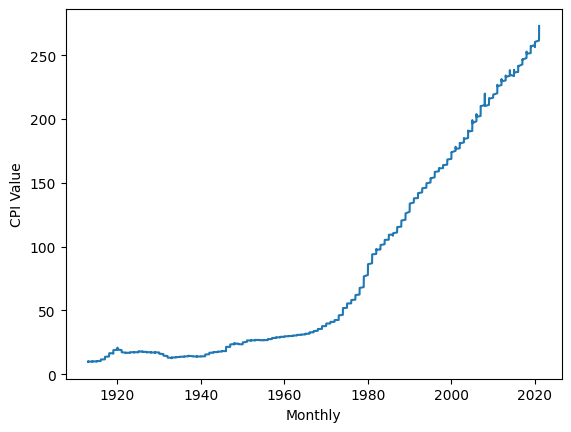

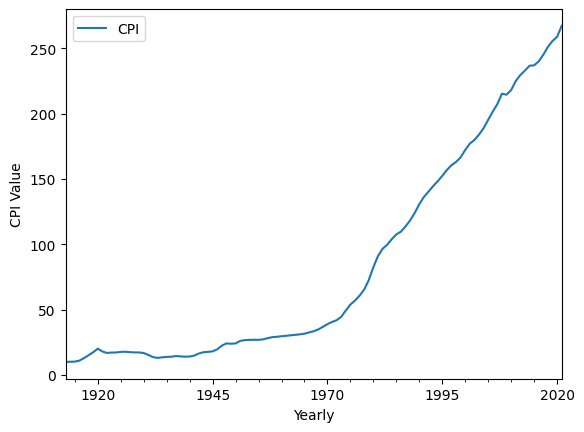

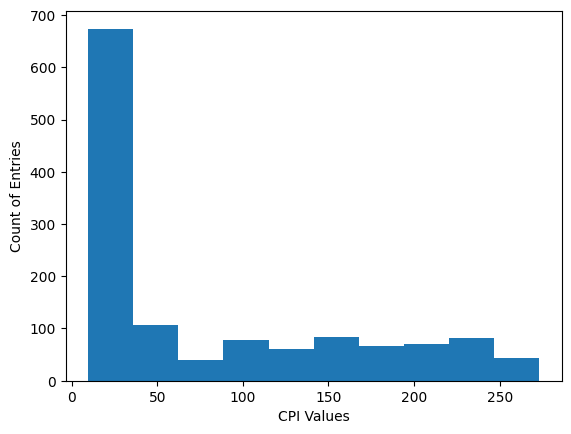

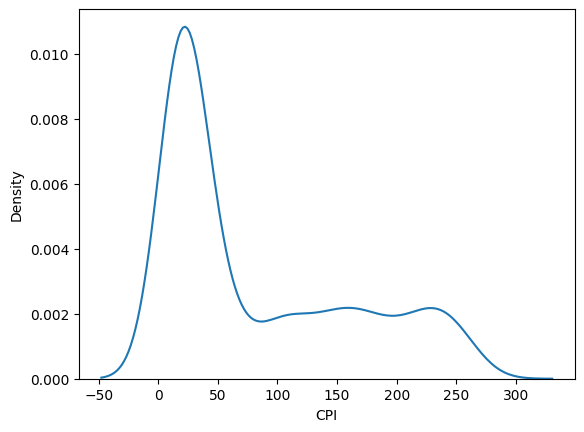

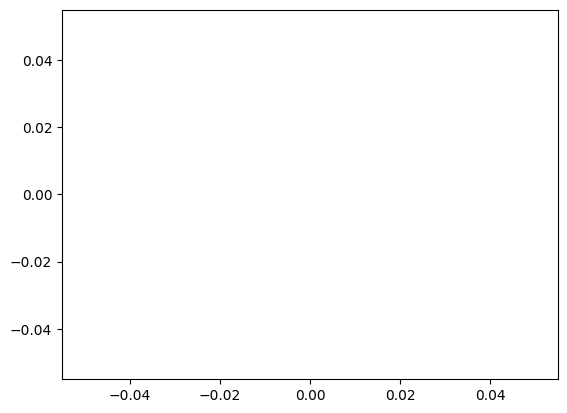

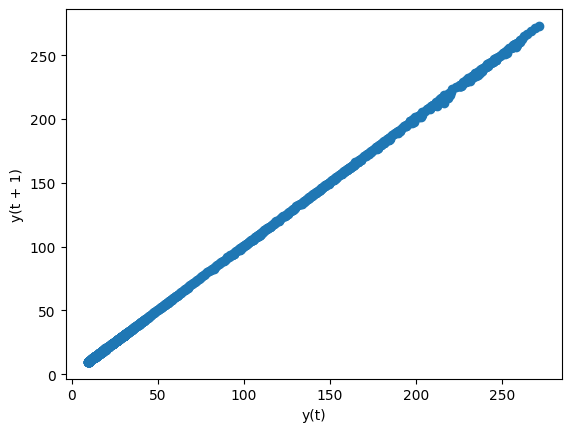

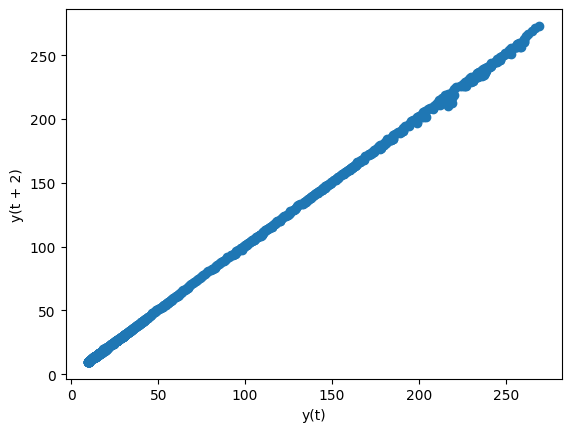

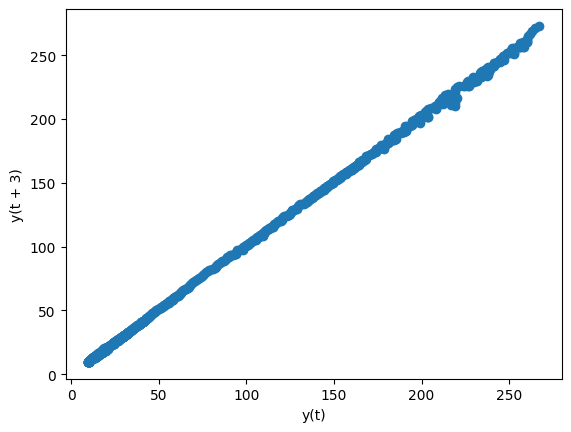

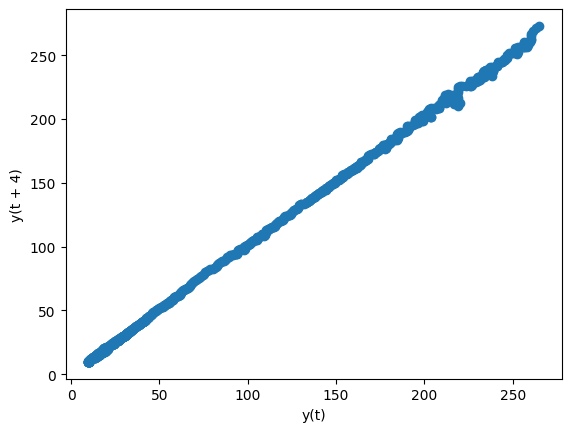

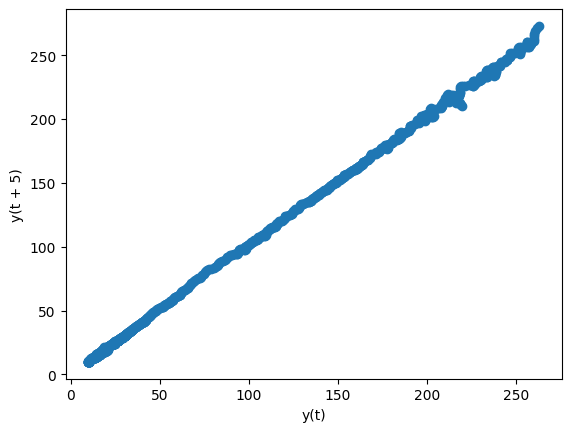

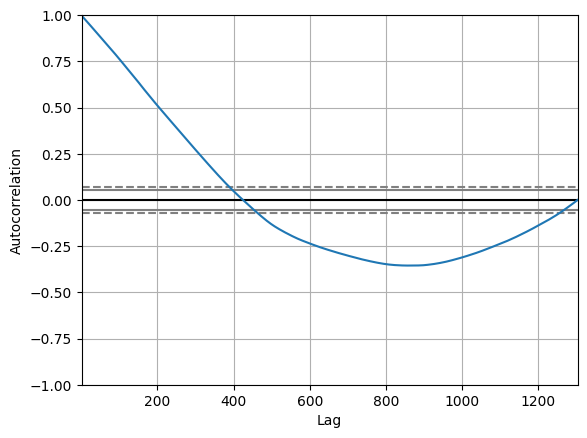

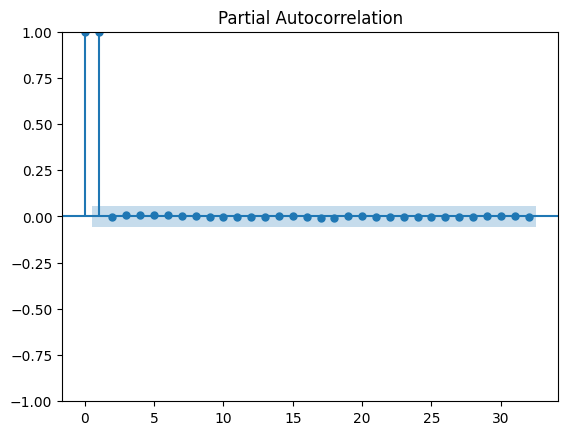

1.0


In [9]:
#df.set_index("date",inplace=True)
plt.plot(df["date"],df["CPI"])
plt.ylabel("CPI Value")
plt.xlabel("Monthly")
plt.show()
#Yearly CPI Increase
yearly_data.plot()
plt.ylabel("CPI Value")
plt.xlabel("Yearly")
plt.show()
#Indicates an upward trend overall with a few in between dips
plt.hist(df["CPI"])
plt.ylabel("Count of Entries")
plt.xlabel("CPI Values")
plt.show()
#Histogram shows saturatiion of datapoints towards the lower end of CPI
sns.kdeplot(df["CPI"])
plt.show()
#The distribution is not normal with being more left skewed and outliers likely present. Transformation
#is likely needed. 
plt.plot()
plt.show()
#plt.lag_plot(df["CPI"])
poss_lags=[1,2,3,4,5]
for poss_lag in poss_lags:
    pd.plotting.lag_plot(df["CPI"], lag=poss_lag)
    plt.show()
#Comparing values across lags, we see that there is indication of strong positive corelation between lag 1 and time, meaning a one period time difference
#from now to the future seem to be strong positive relationshsip. As the difference from the present to the future increases in lags with time going on there is a weaker
#relation it seems 

#Ploting auto-corelation plots
autocorrelation_plot(df["CPI"])
#There is not interchance of positive to negative corelations so there is not much seasonality involved in the dataset. There does not seem to be strong corelation
#between lag 400 and a few months and then it becomes negative. The same is true for the end point of the lags. Therefore there are in period of time when
#the corelation between lags changes from positive to negative. There is no trend present as well. 
plot_pacf(df["CPI"])
plt.show()
#The PACF indicated that the corelation between the present and first few lags is high whereas the effect of higher lags on the present is insignificant

#Running the adf test to check for stationaryness
print(adfuller(df["CPI"])[1])
#As the value is above the threshold of 0.05 then it indicates that the data is not stationary, differencing needs to be done to correct it

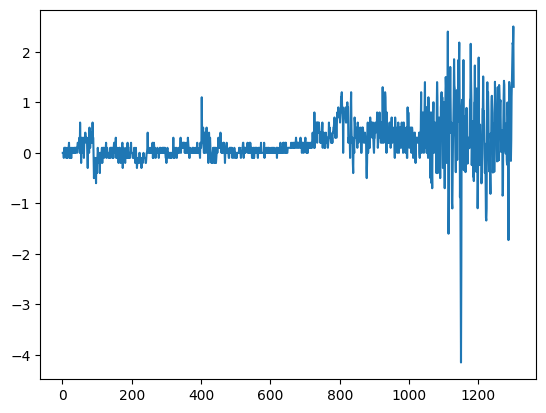

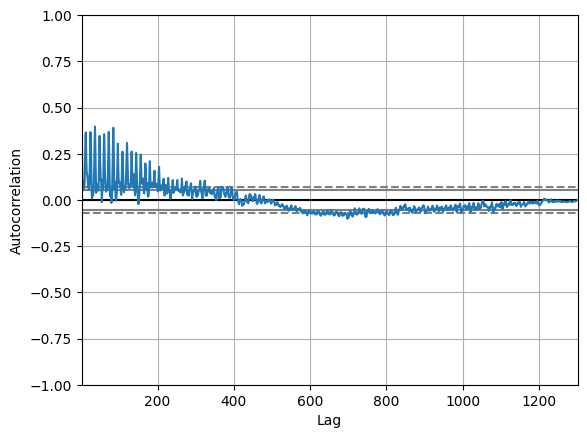

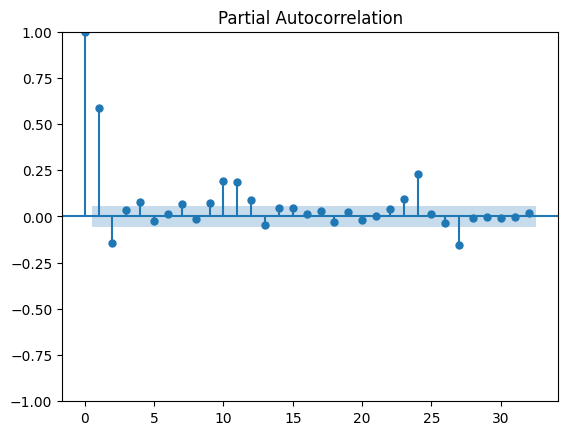

Null Hypothesis test 0.22774934843207661


In [34]:
#We will be applying differencing to the dataset to achieve a form of state where the data is stationary. By having the dataset as Yt-Yt-1 we 
#we hope to the timeseries as stationary contain corelation between periods for Arima to be used. If corelation is not used a random walk model would
#need to be used. 
df_diff=df["CPI"].diff().dropna()
df_diff.plot()
plt.show()
autocorrelation_plot(df_diff)
plt.show()
plot_pacf(df_diff)
plt.show()
print("Null Hypothesis test",adfuller(df_diff)[1])
#As the ADF Test result is greater than 0.05 it failed the time series is still not stationary. Through the acf plots there are indications of high
#autocorelation between initial consequent times and less corelation later on. The same is true for the PACF plots where there is higher high
#autocorelation the first two lags and later on between the 10-11th, 20-21st ones
#2nd Order Differencing is needed in this case. 

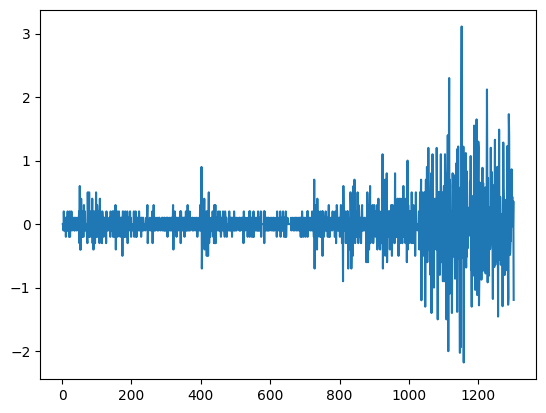

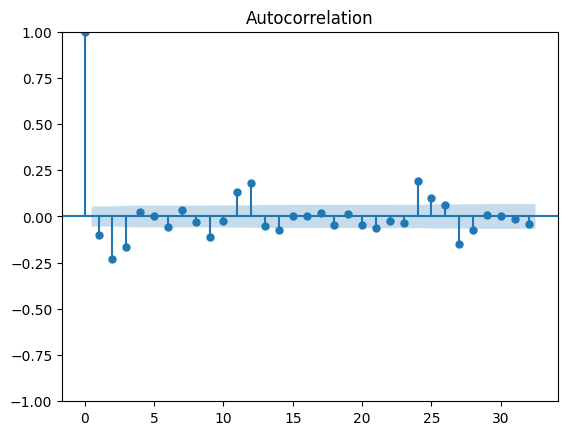

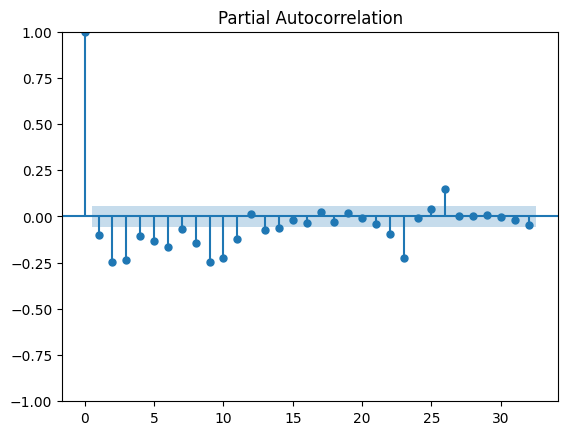

Null Hypothesis test 3.1371836745181235e-26


In [29]:
df_diff_2=df_diff.diff().dropna()
df_diff_2.plot()
plt.show()
plot_acf(df_diff_2)
plt.show()
plot_pacf(df_diff_2)
plt.show()
print("Null Hypothesis test",adfuller(df_diff_2)[1])
#The ADF test results in a value lower than 0.05 so the series is stationary and an Arima model can be used on the dataset now. 

In [40]:
df_diff_2
#print(len(df))
df["differenced_2"]=df_diff_2
df.dropna()

,Yearmon,CPI,differenced_2
2,01-03-1913,9.800,0.000000e+00
3,01-04-1913,9.800,0.000000e+00
4,01-05-1913,9.700,-1.000000e-01
5,01-06-1913,9.800,2.000000e-01
6,01-07-1913,9.900,-1.776357e-15
...,...,...,...
1298,01-03-2021,264.877,4.310000e-01
1299,01-04-2021,267.054,3.140000e-01
1300,01-05-2021,269.195,-3.600000e-02
1301,01-06-2021,271.696,3.600000e-01


In [41]:
#Based on PACF-AR would be 11, based on ACF-MA would be 3
#splitting the dataset into train and test
#msk=(df.index < len(df)-30)
#df_train=df[msk].copy()
#df_test=df[~msk].copy()
df_train=df[:1273]
df_test=df[1273:]
print("df_train",len(df_train))
print("df_test",len(df_test))

df_train 1273
df_test 30


In [41]:
print("Original Length",len(df))
print("Train Dataset",len(df_train))
print("Test Dataset",len(df_test))

Original Length 1303
Train Dataset 1273
Test Dataset 30


In [43]:
model=ARIMA(df_train["CPI"], order=(2,2,5))
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                 1273
Model:                 ARIMA(2, 2, 5)   Log Likelihood                -392.223
Date:                Sat, 22 Jun 2024   AIC                            800.446
Time:                        22:16:47   BIC                            841.626
Sample:                             0   HQIC                           815.914
                               - 1273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4036      0.023    -17.315      0.000      -0.449      -0.358
ar.L2         -0.8894      0.029    -30.432      0.000      -0.947      -0.832
ma.L1         -0.0041      0.031     -0.134      0.8

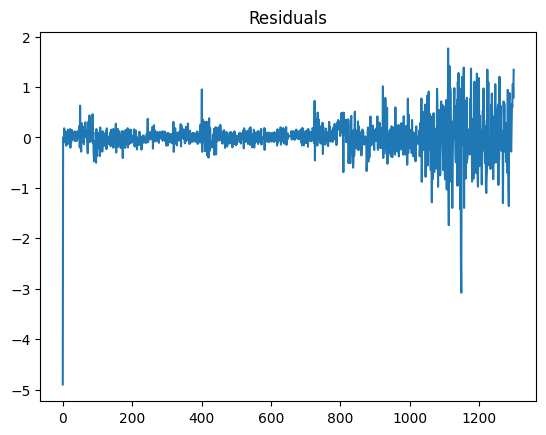

In [98]:
plt.title("Residuals")
residuals=model_fit.resid[1:]
pyplot.plot(residuals)
#plyplot.plot(residuals,title="Density",kind="kde",ax=ax[1])
plt.show()


In [59]:
history=[x for x in df_train["CPI"]]
predictions=list()
for t in range(len(df_test)):
    model=ARIMA(history,order=(2,2,5))
    model_fit=model.fit()
    output=model_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=list(df_test["CPI"])[t]
    history.append(obs)
    

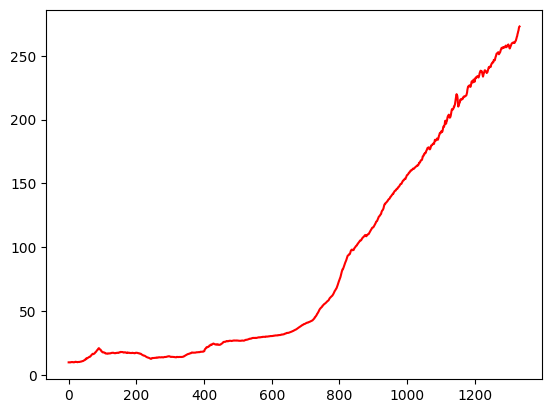

In [54]:
pyplot.plot(predictions,color="red")


0.6984642941005582
0.5731945188876324


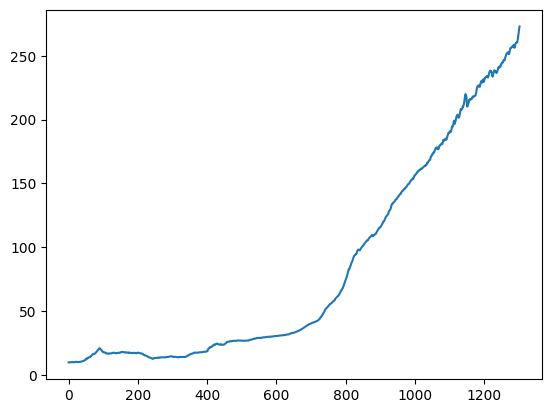

In [93]:
#pyplot.plot(predictions,color="red")
pyplot.plot(history)
mae=mean_absolute_error(df_test["CPI"], predictions)
rms = mean_squared_error(df_test["CPI"], predictions, squared=False)
print(rms)
print(mae)

In [38]:
predictions=model_fit.predict(n_periods=len(df_test["CPI"]))


In [85]:
df_prophet_train

,Yearmon,CPI,differenced_2
0,01-01-1913,9.800,NaN
1,01-02-1913,9.800,NaN
2,01-03-1913,9.800,0.000
3,01-04-1913,9.800,0.000
4,01-05-1913,9.700,-0.100
...,...,...,...
1268,01-09-2018,252.439,0.153
1269,01-10-2018,252.885,0.153
1270,01-11-2018,252.038,-1.293
1271,01-12-2018,251.233,0.042


In [83]:
df_prophet=df.rename(columns={'Yearmon': 'ds', 'differenced_2': 'y'}) 
df_prophet['ds']= to_datetime(df_prophet['ds'])
df_prophet.drop(columns="CPI",inplace=True)

In [86]:
df_prophet_train=df_prophet[:1273]
df_prophet_test=df_prophet[1273:]

In [73]:
df
#1970, 1995
cutoffs = pd.to_datetime(['1970-01-01', '1995-01-01'])
#df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

In [87]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_prophet_train)  # Fit model with given params
    df_cv = cross_validation(m,cutoffs=cutoffs ,horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

22:38:56 - cmdstanpy - INFO - Chain [1] start processing
22:38:56 - cmdstanpy - INFO - Chain [1] done processing
22:38:57 - cmdstanpy - INFO - Chain [1] start processing
22:38:57 - cmdstanpy - INFO - Chain [1] start processing
22:38:57 - cmdstanpy - INFO - Chain [1] done processing
22:38:57 - cmdstanpy - INFO - Chain [1] done processing
22:38:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
22:38:57 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:39:00 - cmdstanpy - INFO - Chain [1] start processing
22:39:00 - cmdstanpy - INFO - Chain [1] start processing
22:39:00 - cmdstanpy - INFO - Chain [1] done processing
22:39:00 - cmdstanpy - INFO - Chain [1] done processing
22:39:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
22:39:00 

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.200254
1                     0.001                     0.10  0.202807
2                     0.001                     1.00  0.201881
3                     0.001                    10.00  0.201452
4                     0.010                     0.01  0.198938
5                     0.010                     0.10  0.200704
6                     0.010                     1.00  0.200848
7                     0.010                    10.00  0.200470
8                     0.100                     0.01  0.198518
9                     0.100                     0.10  0.200222
10                    0.100                     1.00  0.200132
11                    0.100                    10.00  0.199976
12                    0.500                     0.01  0.198420
13                    0.500                     0.10  0.200107
14                    0.500                     1.00  0

In [88]:
m=Prophet(changepoint_prior_scale=0.500,seasonality_prior_scale= 10)
m_fit=m.fit(df_prophet_train)
future=m_fit.make_future_dataframe(periods=30)
forecast=m.predict(future)

22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:57 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
df_train

,ds,y
0,1913-01-01,9.800
1,1913-01-02,9.800
2,1913-01-03,9.800
3,1913-01-04,9.800
4,1913-01-05,9.700
...,...,...
1268,2018-01-09,252.439
1269,2018-01-10,252.885
1270,2018-01-11,252.038
1271,2018-01-12,251.233


In [89]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1913-01-01,0.209201,-0.362627,0.586948,0.209201,0.209201,-0.069795,-0.069795,-0.069795,-0.042090,-0.042090,-0.042090,-0.027705,-0.027705,-0.027705,0.0,0.0,0.0,0.139406
1,1913-01-02,0.209201,-0.393378,0.550434,0.209201,0.209201,-0.122190,-0.122190,-0.122190,0.008099,0.008099,0.008099,-0.130289,-0.130289,-0.130289,0.0,0.0,0.0,0.087011
2,1913-01-03,0.209200,-0.473620,0.504714,0.209200,0.209200,-0.214309,-0.214309,-0.214309,-0.015952,-0.015952,-0.015952,-0.198356,-0.198356,-0.198356,0.0,0.0,0.0,-0.005108
3,1913-01-04,0.209200,-0.490789,0.491681,0.209200,0.209200,-0.230725,-0.230725,-0.230725,0.006598,0.006598,0.006598,-0.237323,-0.237323,-0.237323,0.0,0.0,0.0,-0.021525
4,1913-01-05,0.209200,-0.466711,0.479404,0.209200,0.209200,-0.211635,-0.211635,-0.211635,0.041835,0.041835,0.041835,-0.253470,-0.253470,-0.253470,0.0,0.0,0.0,-0.002435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,2019-01-27,0.211729,-4.144453,-3.133015,0.211729,0.211729,-3.806782,-3.806782,-3.806782,0.041835,0.041835,0.041835,-3.848616,-3.848616,-3.848616,0.0,0.0,0.0,-3.595053
1299,2019-01-28,0.211730,-4.326345,-3.377267,0.211730,0.211730,-4.063571,-4.063571,-4.063571,0.007299,0.007299,0.007299,-4.070870,-4.070870,-4.070870,0.0,0.0,0.0,-3.851842
1300,2019-01-29,0.211730,-4.502783,-3.554411,0.211730,0.211730,-4.254905,-4.254905,-4.254905,-0.005788,-0.005788,-0.005788,-4.249118,-4.249118,-4.249118,0.0,0.0,0.0,-4.043175
1301,2019-01-30,0.211731,-4.703046,-3.768264,0.211731,0.211731,-4.418952,-4.418952,-4.418952,-0.042090,-0.042090,-0.042090,-4.376862,-4.376862,-4.376862,0.0,0.0,0.0,-4.207221


MAE: 1.675839
MAE: 1.6758388281476861
RMSE 2.2272047374635173


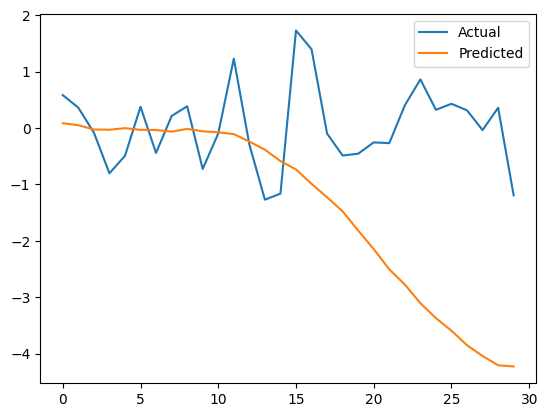

In [94]:
#print(forecast)
y_true=df_prophet_test["y"].values
y_pred=forecast["yhat"][-30:].values
mae=mean_absolute_error(y_true, y_pred)
print("MAE: %f" %mae)
print("MAE:",mae)
rms = mean_squared_error(y_true, y_pred, squared=False)
print("RMSE",rms)
#plot expected vs actual
plt.plot(y_true,label="Actual")
plt.plot(y_pred,label="Predicted")
plt.legend()
plt.show()